Binary 5/6 (ER + NU) B)

mRNA localization using binary classification (endoplasmic reticulum/nucleus) (part 1): basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance), threshold 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [3]:
#data initialization

#Endoplasmic reticulum (label = 1)
ER_train = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_train_CSV.csv")
ER_test = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")

print("ER TRAIN, TEST SHAPE:", ER_train.shape, ",", ER_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

ER TRAIN, TEST SHAPE: (296, 1026) , (74, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:

#Group 5: ER + NU

frames_EN_tra = [ER_train, NU_train]
frames_EN_tes = [ER_test, NU_test]

ER_NU_train = pd.concat(frames_EN_tra)
ER_NU_test = pd.concat(frames_EN_tes)


In [6]:

print("ER + NU TRAIN, TEST SHAPE:", ER_NU_train.shape, ",", ER_NU_test.shape)


ER + NU TRAIN, TEST SHAPE: (936, 1026) , (234, 1026)


In [7]:
ER_NU_test.head(77)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_9547#3911|1|testing,1,0.001311,0.000087,0.000262,0.000262,0.000000,0.000437,0.000175,0.000175,...,0.000087,0.000262,0.000175,0.000262,0.001224,0.000612,0.000175,0.000087,0.000175,0.000175
1,mRNALoc_11948#55102|1|testing,1,0.002614,0.000991,0.001893,0.003245,0.001532,0.000811,0.000541,0.001532,...,0.000180,0.002614,0.001442,0.001712,0.002073,0.001532,0.003335,0.002704,0.002524,0.003064
2,mRNALoc_18167#84629|1|testing,1,0.002457,0.000472,0.000567,0.000284,0.000189,0.000756,0.000095,0.000661,...,0.000378,0.000189,0.000284,0.000378,0.000472,0.000756,0.000567,0.000378,0.000378,0.001417
3,mRNALoc_4038#1952|1|testing,1,0.001044,0.000000,0.000854,0.000285,0.000095,0.000380,0.000190,0.000190,...,0.000285,0.000664,0.000759,0.001139,0.000759,0.000664,0.000475,0.000949,0.000569,0.001044
4,mRNALoc_19976#9881|1|testing,1,0.002954,0.001143,0.002192,0.001620,0.001239,0.001239,0.000572,0.000572,...,0.000191,0.001715,0.002668,0.000858,0.001429,0.000667,0.000667,0.001620,0.001810,0.002573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,mRNALoc_17982#84230|1|testing,1,0.004165,0.002777,0.002360,0.005137,0.002915,0.000972,0.000000,0.002221,...,0.000416,0.003193,0.002777,0.001666,0.001666,0.003054,0.004998,0.003193,0.003610,0.006247
73,mRNALoc_19858#9728|1|testing,1,0.009463,0.002922,0.003896,0.002922,0.002087,0.000974,0.000278,0.002922,...,0.000139,0.002644,0.002505,0.002505,0.001252,0.002087,0.003062,0.001392,0.003201,0.002783
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR ER+NU
noname_EN_train = ER_NU_train.drop("#", axis="columns")
noname_EN_test = ER_NU_test.drop("#", axis="columns")


ER_NU_X_train = noname_EN_train.drop("label", axis="columns")
ER_NU_y_train = noname_EN_train["label"]

ER_NU_X_test = noname_EN_test.drop("label", axis="columns")
ER_NU_y_test = noname_EN_test["label"]

print("ER + NU X train:", ER_NU_X_train.shape)
print("ER + NU y train:", ER_NU_y_train.shape)
print("ER + NU X test:", ER_NU_X_test.shape)
print("ER + NU y test:", ER_NU_y_test.shape)

ER + NU X train: (936, 1024)
ER + NU y train: (936,)
ER + NU X test: (234, 1024)
ER + NU y test: (234,)


In [9]:
# Create data pools for feature importance/selection for ER + NU

EN_feature_names = list(ER_NU_X_train.columns)
print("Number of features:", len(EN_feature_names))

EN_train_pool = Pool(ER_NU_X_train, ER_NU_y_train, feature_names=EN_feature_names)

EN_test_pool = Pool(ER_NU_X_test, ER_NU_y_test)

print("*ER, Nucleus Pools created")

Number of features: 1024
*ER, Nucleus Pools created


    Method 1: Initial classification (without feature importance, selection or auto_class_weights)

In [10]:
EN_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to EN data

EN_binary_model.fit(EN_train_pool)

Learning rate set to 0.07886
0:	learn: 0.6648789	total: 407ms	remaining: 6m 46s
1:	learn: 0.6429696	total: 529ms	remaining: 4m 23s
2:	learn: 0.6224805	total: 660ms	remaining: 3m 39s
3:	learn: 0.6033198	total: 779ms	remaining: 3m 13s
4:	learn: 0.5849616	total: 947ms	remaining: 3m 8s
5:	learn: 0.5673350	total: 1.15s	remaining: 3m 9s
6:	learn: 0.5504222	total: 1.29s	remaining: 3m 3s
7:	learn: 0.5349255	total: 1.41s	remaining: 2m 55s
8:	learn: 0.5234004	total: 1.55s	remaining: 2m 50s
9:	learn: 0.5090158	total: 1.68s	remaining: 2m 46s
10:	learn: 0.4963004	total: 1.87s	remaining: 2m 48s
11:	learn: 0.4862226	total: 2.03s	remaining: 2m 46s
12:	learn: 0.4772793	total: 2.19s	remaining: 2m 46s
13:	learn: 0.4682609	total: 2.34s	remaining: 2m 44s
14:	learn: 0.4593705	total: 2.5s	remaining: 2m 44s
15:	learn: 0.4505307	total: 2.65s	remaining: 2m 43s
16:	learn: 0.4405501	total: 2.8s	remaining: 2m 42s
17:	learn: 0.4335389	total: 2.92s	remaining: 2m 39s
18:	learn: 0.4266199	total: 3.07s	remaining: 2m 38

In [13]:
#Check parameters used in this model fit

EN_bin_params = EN_binary_model.get_all_params()
print("Basic model parameters:", EN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07885999977588654,

In [14]:
#Prediction using X_test
EN_y_pred = EN_binary_model.predict(ER_NU_X_test)

#Predication probability

EN_y_prob = EN_binary_model.predict_proba(ER_NU_X_test)

In [17]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Endoplasmic reticulum & nucleus")

EN_cr = classification_report(ER_NU_y_test, EN_y_pred, digits=4)
print(EN_cr)

print('Accuracy score: ', accuracy_score(ER_NU_y_test, EN_y_pred))

EN_f1 = f1_score(ER_NU_y_test, EN_y_pred, average='macro')
print(f"\nF1 Score: {EN_f1}")

# print('Roc auc score : ', roc_auc_score(ER_NU_y_test, EN_y_prob))

Model 1: Basic model - Endoplasmic reticulum & nucleus
              precision    recall  f1-score   support

           1     0.1765    0.2027    0.1887        74
           3     0.6040    0.5625    0.5825       160

    accuracy                         0.4487       234
   macro avg     0.3902    0.3826    0.3856       234
weighted avg     0.4688    0.4487    0.4580       234

Accuracy score:  0.44871794871794873

F1 Score: 0.3856017585638396


In [18]:
# Confusion matrix for selected data

print("real values shape:", ER_NU_y_test.shape)
print("prediction shape:", EN_y_pred.shape)

EN_y_pred_fl = EN_y_pred
print("flattened prediction values shape:", EN_y_pred_fl.ravel().shape, "\n")

EN_cMatrix = confusion_matrix(ER_NU_y_test, EN_y_pred_fl)
print(EN_cMatrix)

real values shape: (234,)
prediction shape: (234, 1)
flattened prediction values shape: (234,) 

[[15 59]
 [70 90]]


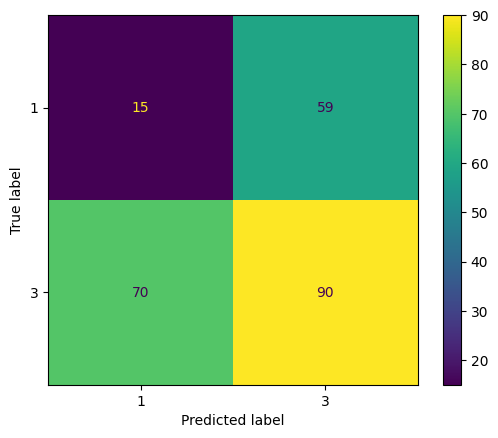

In [19]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EN_cMatrix, display_labels=EN_binary_model.classes_)
disp.plot()
plt.show()

    Method 4: Feature importance-based feature selection with threshold: > 0

In [12]:
#Feature importances for CM pair

EN_feat_importances = EN_binary_model.get_feature_importance(prettified=True)
EN_feat_importances.head(100)

,Feature Id,Importances
0,ATCCC,1.320672
1,ACAGA,1.109360
2,CTAGT,1.082442
3,AAAAA,1.062191
4,GGGGC,0.933315
...,...,...
95,ACAAA,0.241399
96,GATAG,0.241255
97,TTAGC,0.241255
98,CCCCG,0.240811


In [13]:
# Show only feature importances above 0

threshold_chosen_features = EN_feat_importances[EN_feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0 (selected features):", num_chosen_features)

    Feature Id  Importances
0        ATCCC     1.320672
1        ACAGA     1.109360
2        CTAGT     1.082442
3        AAAAA     1.062191
4        GGGGC     0.933315
..         ...          ...
970      CCTGT     0.000229
971      CTGGA     0.000222
972      ACGCT     0.000166
973      TAATC     0.000144
974      ACTCC     0.000050

[975 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 975


In [14]:
print("Sum of total feature importances: ", sum(EN_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000014
Sum of feature importances > 0:  100.00000000000014


In [15]:
# Select features with importance values above 0.1

EN_selected_feat = EN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(EN_selected_feat)

In [16]:
ER_NU_X_train.shape

(936, 1024)

In [17]:
# See original training set

ER_NU_X_train.head(299)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.002263,0.001006,0.001090,0.001341,0.001760,0.000922,0.000168,0.001593,0.000922,0.000419,...,0.000168,0.001174,0.002012,0.001090,0.000922,0.001760,0.001006,0.001425,0.001257,0.001760
295,0.003929,0.001135,0.001572,0.000960,0.001135,0.000786,0.000175,0.000699,0.000873,0.001310,...,0.000175,0.001572,0.001746,0.000960,0.001222,0.001222,0.000611,0.000873,0.001484,0.001310
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835
1,0.000000,0.000000,0.000000,0.001450,0.000000,0.000725,0.000000,0.000000,0.000725,0.000000,...,0.000000,0.000725,0.003626,0.001450,0.001450,0.000725,0.000725,0.000725,0.001450,0.000000


In [18]:
#Create training set with selected features 

EN_X_train_selected = ER_NU_X_train[EN_selected_feat]
EN_X_train_selected.head()

,ATCCC,ACAGA,CTAGT,AAAAA,GGGGC,TGGGG,GATGC,AGAAG,TCGTG,AAAGC,...,TAAAA,ATTTT,CTCCA,ACTTG,AGGCA,CCTGT,CTGGA,ACGCT,TAATC,ACTCC
0,0.000722,0.001443,0.000481,0.004570,0.000722,0.001924,0.000962,0.003608,0.000000,0.002165,...,0.002646,0.002165,0.001443,0.001443,0.002646,0.001443,0.001203,0.0,0.000240,0.000481
1,0.000325,0.001301,0.000976,0.007154,0.000488,0.000813,0.000325,0.003415,0.000650,0.001463,...,0.002602,0.003089,0.000813,0.001301,0.001301,0.000976,0.001138,0.0,0.000488,0.000976
2,0.001007,0.001510,0.000336,0.002685,0.002685,0.002014,0.000839,0.001007,0.000671,0.001007,...,0.001846,0.001007,0.002685,0.000168,0.002014,0.002517,0.003021,0.0,0.000336,0.001678
3,0.000805,0.000000,0.000000,0.010459,0.003218,0.004023,0.000000,0.003218,0.000000,0.000000,...,0.001609,0.000000,0.003218,0.000805,0.000000,0.001609,0.002414,0.0,0.000000,0.000805
4,0.001803,0.000451,0.001353,0.000902,0.000902,0.003156,0.001353,0.000902,0.000902,0.001353,...,0.000451,0.003156,0.000451,0.000000,0.002705,0.001353,0.004959,0.0,0.000451,0.001353


In [19]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(EN_X_train_selected.columns) == EN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [20]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", EN_X_train_selected.shape)
print("Shape of y_train (number of labels):", ER_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (936, 975)
Shape of y_train (number of labels): (936,)


In [21]:
# Create pool object for selected feature data
print("Original number of features:", len(EN_feature_names), "\n Number of selected features:", len(EN_selected_feat))

EN_selected_train_pool = Pool(EN_X_train_selected, ER_NU_y_train, feature_names=EN_selected_feat)

Original number of features: 1024 
 Number of selected features: 975


In [22]:
#Create new model for data with selected features
EN_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

EN_FIFS_model.fit(EN_selected_train_pool)

Learning rate set to 0.07886
0:	learn: 0.6683229	total: 240ms	remaining: 3m 59s
1:	learn: 0.6411302	total: 375ms	remaining: 3m 7s
2:	learn: 0.6194782	total: 501ms	remaining: 2m 46s
3:	learn: 0.5997889	total: 629ms	remaining: 2m 36s
4:	learn: 0.5825566	total: 762ms	remaining: 2m 31s
5:	learn: 0.5673460	total: 897ms	remaining: 2m 28s
6:	learn: 0.5529483	total: 1.05s	remaining: 2m 29s
7:	learn: 0.5398925	total: 1.18s	remaining: 2m 26s
8:	learn: 0.5274396	total: 1.34s	remaining: 2m 27s
9:	learn: 0.5158981	total: 1.47s	remaining: 2m 25s
10:	learn: 0.5010970	total: 1.6s	remaining: 2m 23s
11:	learn: 0.4916533	total: 1.71s	remaining: 2m 21s
12:	learn: 0.4793836	total: 1.85s	remaining: 2m 20s
13:	learn: 0.4708653	total: 1.97s	remaining: 2m 18s
14:	learn: 0.4624326	total: 2.09s	remaining: 2m 17s
15:	learn: 0.4526628	total: 2.29s	remaining: 2m 20s
16:	learn: 0.4443429	total: 2.42s	remaining: 2m 20s
17:	learn: 0.4361323	total: 2.56s	remaining: 2m 19s
18:	learn: 0.4283445	total: 2.7s	remaining: 2m 

In [23]:
#Check parameters used in this model fit

EN_FIFS_params = EN_FIFS_model.get_all_params()
print("Basic model parameters:", EN_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07885999977588654,

In [24]:
#Prediction using X_test only for selected features data
EN_FIFS_y_pred = EN_FIFS_model.predict(ER_NU_X_test)

#Predication probability for selected features data

EN_FIFS_y_prob = EN_FIFS_model.predict_proba(ER_NU_X_test)

In [25]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold 0 - Endoplasmic reticulum & nucleus")

print("Number of chosen features:", num_chosen_features, "\n")

EN_FIFS_cr = classification_report(ER_NU_y_test, EN_FIFS_y_pred, digits=4)
print(EN_FIFS_cr)

print('Accuracy score: ', accuracy_score(ER_NU_y_test, EN_FIFS_y_pred))

EN_FIFS_f1 = f1_score(ER_NU_y_test, EN_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {EN_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(ER_NU_y_test, EN_FIFS_y_prob))

Model 4: Feature selection (PredictionValuesChange) w/ threshold 0 - Endoplasmic reticulum & nucleus
Number of chosen features: 975 

              precision    recall  f1-score   support

           1     0.1591    0.1892    0.1728        74
           3     0.5890    0.5375    0.5621       160

    accuracy                         0.4274       234
   macro avg     0.3741    0.3633    0.3675       234
weighted avg     0.4531    0.4274    0.4390       234

Accuracy score:  0.42735042735042733

F1 Score: 0.3674655047204067


In [26]:
# Confusion matrix for selected data

print("real values shape:", ER_NU_y_test.shape)
print("prediction shape:", EN_FIFS_y_pred.shape)

EN_FIFS_y_pred_fl = EN_FIFS_y_pred
print("flattened prediction values shape:", EN_FIFS_y_pred_fl.ravel().shape, "\n")

EN_FIFS_cMatrix = confusion_matrix(ER_NU_y_test, EN_FIFS_y_pred_fl)
print(EN_FIFS_cMatrix)

real values shape: (234,)
prediction shape: (234, 1)
flattened prediction values shape: (234,) 

[[14 60]
 [74 86]]


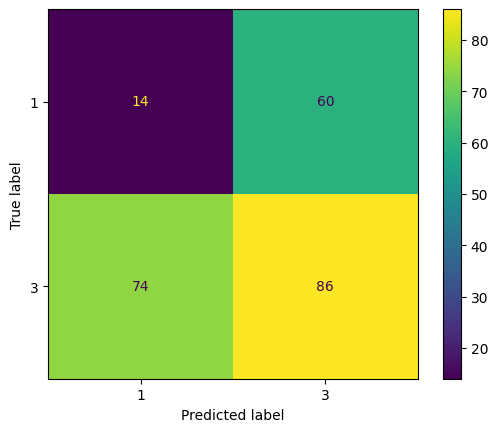

In [27]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EN_FIFS_cMatrix, display_labels=EN_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 5: Modelling using feature selection based on feature importance values (SHAP Values), threshold > 0

In [28]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(EN_binary_model)

In [29]:
#SHAP values for X_train
EN_shap_values = explainer.shap_values(ER_NU_X_train)

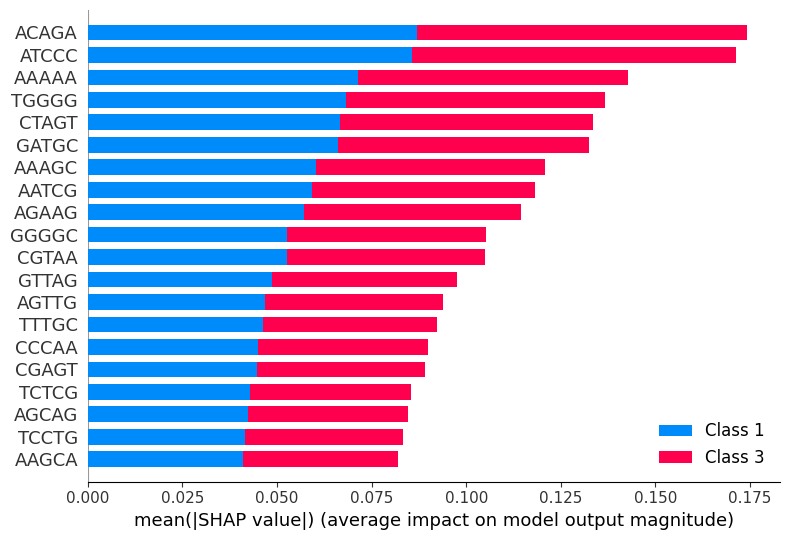

In [30]:
shap.summary_plot(EN_shap_values, ER_NU_X_train, plot_size=0.2, class_names=["Class 1", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


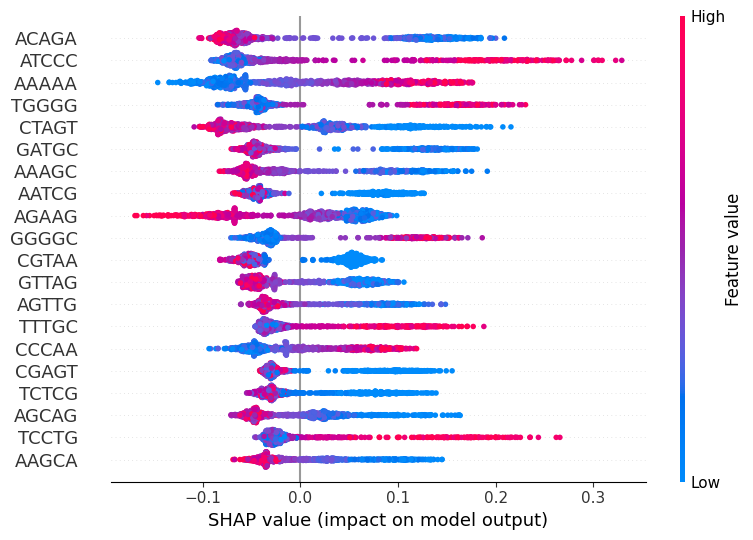

In [31]:
shap.summary_plot(EN_shap_values[0], ER_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


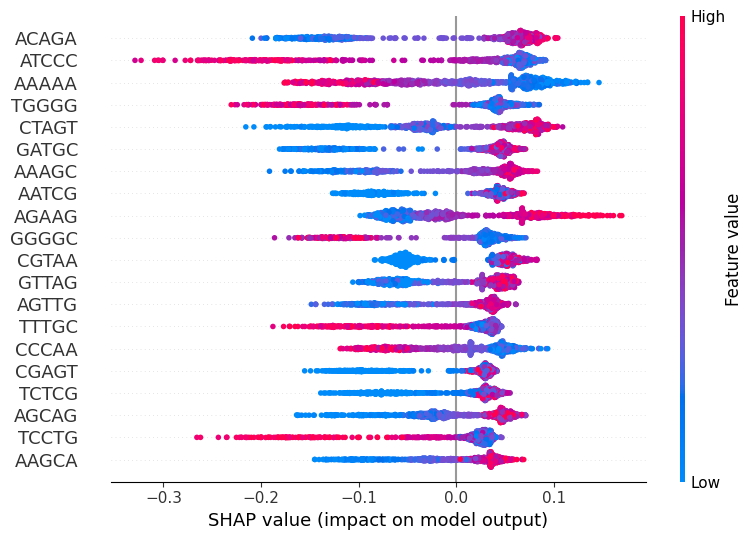

In [32]:
shap.summary_plot(EN_shap_values[1], ER_NU_X_train, plot_size=0.2)

In [33]:
shap_df = pd.DataFrame(EN_shap_values[0], columns=ER_NU_X_train.columns)


In [34]:
EN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [35]:
EN_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,ATCCC,0.174511
1,TGGGG,0.154345
2,GATGC,0.131765
3,ACAGA,0.129739
4,AGCCA,0.125387
...,...,...
95,AAACA,0.026563
96,GTCGA,0.026429
97,AATGA,0.025985
98,CCCCG,0.025647


In [36]:
# shap.summary_plot(EN_shap_values[0], ER_NU_X_train, show=False, max_display=30, plot_size=0.2)

In [37]:
# #Try####

# vals= np.abs(EN_shap_values).mean(0)

# newtry_feature_importance = pd.DataFrame(list(zip(ER_NU_X_train.columns, sum(vals))), columns=['col_name','feature_importanEN_vals'])
# newtry_feature_importance.sort_values(by=['feature_importanEN_vals'], ascending=False,inplace=True)
# newtry_feature_importance

In [38]:
# newtry_feature_importance.head(10)

In [39]:
#Classifier results with EN_feature_importance

In [41]:
# Show only feature importances above 0

EN_SHAP_thres_chosen = EN_shap_FI[EN_shap_FI['Importances'] > 0]
EN_shap_num_chosen = len(EN_SHAP_thres_chosen)

print(EN_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0 (selected features):", EN_shap_num_chosen)

    Feature Id  Importances
0        ATCCC     0.174511
1        TGGGG     0.154345
2        GATGC     0.131765
3        ACAGA     0.129739
4        AGCCA     0.125387
..         ...          ...
970      CTGGA     0.000057
971      CCTGT     0.000057
972      TAATC     0.000052
973      CCTTG     0.000031
974      ACTCC     0.000012

[975 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 975


In [42]:
print("Sum of total feature importances: ", sum(EN_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(EN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  10.128305326529983


In [43]:
# Select features with importance values above 0.1

EN_shap_selected_feat = EN_shap_FI[:EN_shap_num_chosen]['Feature Id'].tolist()

# print(EN_shap_selected_feat)

In [44]:
ER_NU_X_train.shape

(936, 1024)

In [45]:
# See original training set

ER_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.001821,0.001336,0.001821,0.000971,0.001700,0.001578,0.000486,0.001821,0.002914,0.001943,...,0.000121,0.001093,0.001457,0.002064,0.001578,0.001578,0.001700,0.000850,0.002793,0.002671
526,0.004372,0.001822,0.002186,0.002550,0.001336,0.000972,0.000364,0.001943,0.002793,0.002308,...,0.000243,0.002186,0.001336,0.001457,0.001457,0.002550,0.002429,0.001579,0.001579,0.006923
527,0.006326,0.001460,0.002311,0.002798,0.002068,0.000973,0.000122,0.001460,0.002920,0.002190,...,0.000608,0.002068,0.002068,0.001095,0.001582,0.001825,0.002311,0.001338,0.002068,0.002433
528,0.005232,0.003042,0.001825,0.003650,0.003285,0.001095,0.001460,0.001825,0.002312,0.001825,...,0.001217,0.000730,0.000730,0.000730,0.000730,0.001338,0.002555,0.001217,0.001825,0.007543


In [46]:
#Create training set with selected features 

EN_X_train_shap_selected = ER_NU_X_train[EN_shap_selected_feat]
EN_X_train_shap_selected.head()

,ATCCC,TGGGG,GATGC,ACAGA,AGCCA,GGGGC,TCCTG,TACTT,TGAAT,AAAGC,...,GCAAA,TACAT,TACGA,ACGCT,CTCCA,CTGGA,CCTGT,TAATC,CCTTG,ACTCC
0,0.000722,0.001924,0.000962,0.001443,0.000962,0.000722,0.002646,0.001443,0.001203,0.002165,...,0.002405,0.000240,0.000000,0.0,0.001443,0.001203,0.001443,0.000240,0.001684,0.000481
1,0.000325,0.000813,0.000325,0.001301,0.001951,0.000488,0.000650,0.001626,0.001463,0.001463,...,0.001789,0.000976,0.000163,0.0,0.000813,0.001138,0.000976,0.000488,0.001138,0.000976
2,0.001007,0.002014,0.000839,0.001510,0.001510,0.002685,0.002853,0.000503,0.000336,0.001007,...,0.000839,0.000336,0.000000,0.0,0.002685,0.003021,0.002517,0.000336,0.002014,0.001678
3,0.000805,0.004023,0.000000,0.000000,0.002414,0.003218,0.002414,0.000000,0.001609,0.000000,...,0.000000,0.000000,0.000000,0.0,0.003218,0.002414,0.001609,0.000000,0.000805,0.000805
4,0.001803,0.003156,0.001353,0.000451,0.002254,0.000902,0.002254,0.000902,0.000902,0.001353,...,0.000902,0.000902,0.000000,0.0,0.000451,0.004959,0.001353,0.000451,0.003607,0.001353


In [47]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(EN_X_train_shap_selected.columns) == EN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [48]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", EN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", ER_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (936, 975)
Shape of y_train (number of labels): (936,)


In [49]:
# Create pool object for selected feature data
print("Original number of features:", len(EN_feature_names), "\n Number of selected features:", len(EN_shap_selected_feat))

EN_shap_selected_train_pool = Pool(EN_X_train_shap_selected, ER_NU_y_train, feature_names=EN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 975


In [50]:
#Create new model for data with selected features
EN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

EN_FIFS_shap_model.fit(EN_shap_selected_train_pool)

Learning rate set to 0.07886
0:	learn: 0.6667368	total: 419ms	remaining: 6m 58s
1:	learn: 0.6449163	total: 552ms	remaining: 4m 35s
2:	learn: 0.6248060	total: 685ms	remaining: 3m 47s
3:	learn: 0.6056544	total: 811ms	remaining: 3m 22s
4:	learn: 0.5868243	total: 945ms	remaining: 3m 8s
5:	learn: 0.5717454	total: 1.1s	remaining: 3m 2s
6:	learn: 0.5569646	total: 1.25s	remaining: 2m 56s
7:	learn: 0.5437083	total: 1.41s	remaining: 2m 54s
8:	learn: 0.5283494	total: 1.55s	remaining: 2m 50s
9:	learn: 0.5148570	total: 1.67s	remaining: 2m 45s
10:	learn: 0.5027148	total: 1.8s	remaining: 2m 41s
11:	learn: 0.4932798	total: 1.92s	remaining: 2m 38s
12:	learn: 0.4832115	total: 2.05s	remaining: 2m 35s
13:	learn: 0.4748997	total: 2.17s	remaining: 2m 32s
14:	learn: 0.4652162	total: 2.29s	remaining: 2m 30s
15:	learn: 0.4552982	total: 2.41s	remaining: 2m 28s
16:	learn: 0.4482110	total: 2.53s	remaining: 2m 26s
17:	learn: 0.4391652	total: 2.65s	remaining: 2m 24s
18:	learn: 0.4331343	total: 2.76s	remaining: 2m 2

In [51]:
#Check parameters used in this model fit

EN_FIFS_shap_params = EN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", EN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07885999977588654,

In [52]:
#Prediction using X_test only for selected features data
EN_FIFS_shap_y_pred = EN_FIFS_shap_model.predict(ER_NU_X_test)

#Predication probability for selected features data

EN_FIFS_shap_y_prob = EN_FIFS_shap_model.predict_proba(ER_NU_X_test)

In [53]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Endoplasmic reticulum & nucleus")

print("Number of chosen features:", len(EN_shap_selected_feat), "\n")

EN_FIFS_shap_cr = classification_report(ER_NU_y_test, EN_FIFS_shap_y_pred, digits=4)
print(EN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(ER_NU_y_test, EN_FIFS_shap_y_pred))

EN_FIFS_shap_f1 = f1_score(ER_NU_y_test, EN_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {EN_FIFS_shap_f1}")

# print('Roc auc score : ', roc_auc_score(ER_NU_y_test, EN_FIFS_shap_y_prob))

Model 5: Feature selection (SHAP) w/ threshold > 0 - Endoplasmic reticulum & nucleus
Number of chosen features: 975 

              precision    recall  f1-score   support

           1     0.1772    0.1892    0.1830        74
           3     0.6129    0.5938    0.6032       160

    accuracy                         0.4658       234
   macro avg     0.3951    0.3915    0.3931       234
weighted avg     0.4751    0.4658    0.4703       234

Accuracy score:  0.4658119658119658

F1 Score: 0.3930905695611578


In [54]:
# Confusion matrix for selected data

print("real values shape:", ER_NU_y_test.shape)
print("prediction shape:", EN_FIFS_shap_y_pred.shape)

EN_FIFS_shap_y_pred_fl = EN_FIFS_shap_y_pred
print("flattened prediction values shape:", EN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

EN_FIFS_shap_cMatrix = confusion_matrix(ER_NU_y_test, EN_FIFS_shap_y_pred_fl)
print(EN_FIFS_shap_cMatrix)

real values shape: (234,)
prediction shape: (234, 1)
flattened prediction values shape: (234,) 

[[14 60]
 [65 95]]


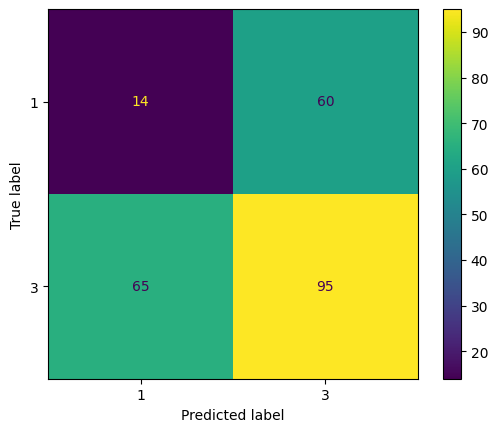

In [55]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EN_FIFS_shap_cMatrix, display_labels=EN_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [60]:
#Classifier results with newtry_feature_importance

In [61]:
# newtry_feature_importance.head(100)

,col_name,feature_importanEN_vals
72,ACAGA,81.519197
213,ATCCC,80.167326
0,AAAAA,66.773095
938,TGGGG,63.939170
459,CTAGT,62.428312
...,...,...
188,AGTTA,14.150397
10,AAAGG,14.137560
1,AAAAC,14.072145
981,TTCCC,14.068185


In [62]:
# # Show only feature importances above 0.1

# EN_newSHAP_thres_chosen = newtry_feature_importance[:100]
# EN_newshap_num_chosen = len(EN_newSHAP_thres_chosen)

# print(EN_newSHAP_thres_chosen)

# print("\nAmount of features with importnace above 0.1 (selected features):", EN_newshap_num_chosen)

    col_name  feature_importanEN_vals
72     ACAGA                81.519197
213    ATCCC                80.167326
0      AAAAA                66.773095
938    TGGGG                63.939170
459    CTAGT                62.428312
..       ...                      ...
188    AGTTA                14.150397
10     AAAGG                14.137560
1      AAAAC                14.072145
981    TTCCC                14.068185
969    TTAGC                13.514560

[100 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 100


In [63]:
# print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanEN_vals))
# print("Sum of feature importances >=0.1: ", sum(EN_newSHAP_thres_chosen.feature_importanEN_vals))

Sum of total feature importances:  6058.01338837711
Sum of feature importances >=0.1:  2888.1939629306094


In [64]:
# # Select features with importance values above 0.1

# EN_newshap_selected_feat = newtry_feature_importance[:EN_newshap_num_chosen]['col_name'].tolist()

# print(EN_newshap_selected_feat)

['ACAGA', 'ATCCC', 'AAAAA', 'TGGGG', 'CTAGT', 'GATGC', 'AAAGC', 'AATCG', 'AGAAG', 'GGGGC', 'CGTAA', 'GTTAG', 'AGTTG', 'TTTGC', 'CCCAA', 'CGAGT', 'TCTCG', 'AGCAG', 'TCCTG', 'AAGCA', 'CAATA', 'CGAAA', 'TCGTG', 'ACACG', 'ACCCT', 'CTGGG', 'ACGAA', 'AGCCA', 'ATTTC', 'GTTCT', 'ATCAC', 'GACGT', 'TGGGC', 'GAAGC', 'GTTGA', 'AAGAT', 'AGAGA', 'TGGTC', 'AGGGA', 'CTAGC', 'AGTTC', 'ACGAT', 'GAAGA', 'AACAC', 'CAAGC', 'GTAGC', 'GCTTG', 'GTCTG', 'AAGCT', 'CCCGG', 'GCTAA', 'GTTGT', 'CGATA', 'GGGCC', 'TAGAG', 'GTAGA', 'GCAGA', 'AGAGT', 'GCTAG', 'CTTAT', 'TTCAT', 'GACAG', 'AAGTT', 'CTCGT', 'GGGCA', 'GAGTG', 'CGTTG', 'TACTT', 'GTCGA', 'TTTCA', 'GAGTT', 'ACAGT', 'TCCTC', 'CAGTA', 'GGGGA', 'TGTGA', 'GGGAG', 'GACTT', 'ACTTT', 'TGTCG', 'GGAAA', 'TAATT', 'GATTT', 'CCTGG', 'TGAAG', 'TGCTA', 'GCTTA', 'TCAGG', 'TCGAA', 'TACAG', 'CCCCG', 'TAGAC', 'GGCTT', 'CCGAG', 'AGGTA', 'AGTTA', 'AAAGG', 'AAAAC', 'TTCCC', 'TTAGC']


In [65]:
# ER_NU_X_train.shape

(936, 1024)

In [66]:
# # See original training set

# ER_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.001821,0.001336,0.001821,0.000971,0.001700,0.001578,0.000486,0.001821,0.002914,0.001943,...,0.000121,0.001093,0.001457,0.002064,0.001578,0.001578,0.001700,0.000850,0.002793,0.002671
526,0.004372,0.001822,0.002186,0.002550,0.001336,0.000972,0.000364,0.001943,0.002793,0.002308,...,0.000243,0.002186,0.001336,0.001457,0.001457,0.002550,0.002429,0.001579,0.001579,0.006923
527,0.006326,0.001460,0.002311,0.002798,0.002068,0.000973,0.000122,0.001460,0.002920,0.002190,...,0.000608,0.002068,0.002068,0.001095,0.001582,0.001825,0.002311,0.001338,0.002068,0.002433
528,0.005232,0.003042,0.001825,0.003650,0.003285,0.001095,0.001460,0.001825,0.002312,0.001825,...,0.001217,0.000730,0.000730,0.000730,0.000730,0.001338,0.002555,0.001217,0.001825,0.007543


In [67]:
# #Create training set with selected features 

# EN_X_train_newshap_selected = ER_NU_X_train[EN_newshap_selected_feat]
# EN_X_train_newshap_selected.head()

,ACAGA,ATCCC,AAAAA,TGGGG,CTAGT,GATGC,AAAGC,AATCG,AGAAG,GGGGC,...,CCCCG,TAGAC,GGCTT,CCGAG,AGGTA,AGTTA,AAAGG,AAAAC,TTCCC,TTAGC
0,0.001443,0.000722,0.004570,0.001924,0.000481,0.000962,0.002165,0.000000,0.003608,0.000722,...,0.000240,0.00024,0.000962,0.000481,0.000962,0.000962,0.001443,0.000962,0.002165,0.000722
1,0.001301,0.000325,0.007154,0.000813,0.000976,0.000325,0.001463,0.000813,0.003415,0.000488,...,0.001301,0.00000,0.000488,0.000976,0.000488,0.000488,0.001301,0.002602,0.001301,0.000488
2,0.001510,0.001007,0.002685,0.002014,0.000336,0.000839,0.001007,0.000000,0.001007,0.002685,...,0.002182,0.00000,0.000503,0.002182,0.000000,0.000168,0.001175,0.001007,0.000839,0.000168
3,0.000000,0.000805,0.010459,0.004023,0.000000,0.000000,0.000000,0.000000,0.003218,0.003218,...,0.000000,0.00000,0.000000,0.000805,0.001609,0.000000,0.000805,0.001609,0.000000,0.000000
4,0.000451,0.001803,0.000902,0.003156,0.001353,0.001353,0.001353,0.000000,0.000902,0.000902,...,0.001353,0.00000,0.000451,0.000451,0.000902,0.000000,0.001353,0.000451,0.000902,0.001353


In [68]:
# # Check whether columns in new training set are the same featues are the ones selected
# if(list(EN_X_train_newshap_selected.columns) == EN_newshap_selected_feat):
#     print("Selected and column features are the same; properly selected");
# else:
#     print("Features not selected properly")

Selected and column features are the same; properly selected


In [69]:
# # Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
# print("Shape of X_train_selected (number of variables/sequences):", EN_X_train_newshap_selected.shape)
# print("Shape of y_train (number of labels):", ER_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (936, 100)
Shape of y_train (number of labels): (936,)


In [70]:
# # Create pool object for selected feature data
# print("Original number of features:", len(EN_feature_names), "\n Number of selected features:", len(EN_newshap_selected_feat))

# EN_newshap_selected_train_pool = Pool(EN_X_train_newshap_selected, ER_NU_y_train, feature_names=EN_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 100


In [71]:
# #Create new model for data with selected features
# EN_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# # Fit new data into same model as before

# EN_FIFS_newshap_model.fit(EN_newshap_selected_train_pool)

Learning rate set to 0.07886
0:	learn: 0.6645053	total: 20ms	remaining: 20s
1:	learn: 0.6398429	total: 35ms	remaining: 17.4s
2:	learn: 0.6191023	total: 50.9ms	remaining: 16.9s
3:	learn: 0.5974483	total: 66.5ms	remaining: 16.6s
4:	learn: 0.5779796	total: 81.1ms	remaining: 16.1s
5:	learn: 0.5596660	total: 94.7ms	remaining: 15.7s
6:	learn: 0.5441731	total: 108ms	remaining: 15.3s
7:	learn: 0.5283309	total: 122ms	remaining: 15.1s
8:	learn: 0.5144693	total: 138ms	remaining: 15.2s
9:	learn: 0.4991728	total: 151ms	remaining: 15s
10:	learn: 0.4848854	total: 165ms	remaining: 14.9s
11:	learn: 0.4725145	total: 180ms	remaining: 14.8s
12:	learn: 0.4619683	total: 194ms	remaining: 14.8s
13:	learn: 0.4514800	total: 208ms	remaining: 14.7s
14:	learn: 0.4423812	total: 222ms	remaining: 14.6s
15:	learn: 0.4327790	total: 236ms	remaining: 14.5s
16:	learn: 0.4251177	total: 252ms	remaining: 14.6s
17:	learn: 0.4168025	total: 266ms	remaining: 14.5s
18:	learn: 0.4088757	total: 281ms	remaining: 14.5s
19:	learn: 0.4

In [72]:
# #Check parameters used in this model fit

# EN_FIFS_newshap_params = EN_FIFS_newshap_model.get_all_params()
# print("Basic model parameters:", EN_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07885999977588654,

In [73]:
# #Prediction using X_test only for selected features data
# EN_FIFS_newshap_y_pred = EN_FIFS_newshap_model.predict(ER_NU_X_test)

# #Predication probability for selected features data

# EN_FIFS_newshap_y_prob = EN_FIFS_newshap_model.predict_proba(ER_NU_X_test)

In [74]:
# # Calculate F1 score and get classification report

# EN_FIFS_newshap_f1 = f1_score(ER_NU_y_test, EN_FIFS_newshap_y_pred, average='macro')
# print(f"F1 Score: {EN_FIFS_newshap_f1}")

# EN_FIFS_newshap_cr = classification_report(ER_NU_y_test, EN_FIFS_newshap_y_pred, digits=4)
# print(EN_FIFS_newshap_cr)

# print('Accuracy score: ', accuracy_score(ER_NU_y_test, EN_FIFS_newshap_y_pred))
# # print('Roc auc score : ', roc_auc_score(ER_NU_y_test, EN_FIFS_newshap_y_prob))

F1 Score: 0.4056462358427715
              precision    recall  f1-score   support

           1     0.1923    0.2027    0.1974        74
           3     0.6218    0.6062    0.6139       160

    accuracy                         0.4786       234
   macro avg     0.4071    0.4045    0.4056       234
weighted avg     0.4860    0.4786    0.4822       234

Accuracy score:  0.47863247863247865


In [75]:
# # Confusion matrix for selected data

# print("real values shape:", ER_NU_y_test.shape)
# print("prediction shape:", EN_FIFS_newshap_y_pred.shape)

# EN_FIFS_newshap_y_pred_fl = EN_FIFS_newshap_y_pred
# print("flattened prediction values shape:", EN_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

# EN_FIFS_newshap_cMatrix = confusion_matrix(ER_NU_y_test, EN_FIFS_newshap_y_pred_fl)
# print(EN_FIFS_newshap_cMatrix)

real values shape: (234,)
prediction shape: (234, 1)
flattened prediction values shape: (234,) 

[[15 59]
 [63 97]]


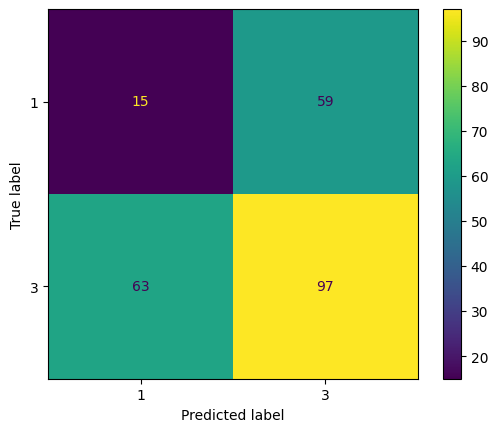

In [76]:
# # Show image of confusion matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=EN_FIFS_newshap_cMatrix, display_labels=EN_FIFS_newshap_model.classes_)
# disp.plot()
# plt.show()